## The Product Pricer  
A model that can estimate how much something costs, from its description.

### Data Curation Part 1.   
Today we'll begin our scrubbing and curating our dataset by focussing on a subest of the data: ***Home Appliances***

The dataset is here:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023  


And the folder with all the product datasets is here:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [4]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [5]:
load_dotenv(override=True)

True

In [6]:
# Login into hugging_face

hf_token = os.getenv("HF_TOKEN")
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
%matplotlib inline

In [8]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

In [9]:
print(f"Number of appliances: {len(dataset): ,}")

Number of appliances:  94,327


In [10]:
# Investigate a particular datapoint

datapoint = dataset[0]
datapoint

{'main_category': 'Industrial & Scientific',
 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)',
 'average_rating': 3.7,
 'rating_number': 61,
 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food',
  '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like',
  '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take 

In [11]:
print(datapoint['title'])
print(datapoint['description'])
print(datapoint['features'])
print(datapoint['details'])
print(datapoint['price'])

# 'details' is a not a dictionary, its a string that contains json
# not all the products have 'price'
# 'description' is a list

ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)
[]
['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out and make you cool', '【Full Monitoring】 Designed with compressor cooling system, operates at low noise and will 

In [12]:
# How many have prices ?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices = prices + 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [13]:
# For those with prices, gather the price and the length

prices = []
lengths = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices.append(price)
            contents = datapoint['title'] + str(datapoint['description']) + str(datapoint['features']) + str(datapoint['details'])
            lengths.append(len(contents))
    except ValueError as e:
        pass


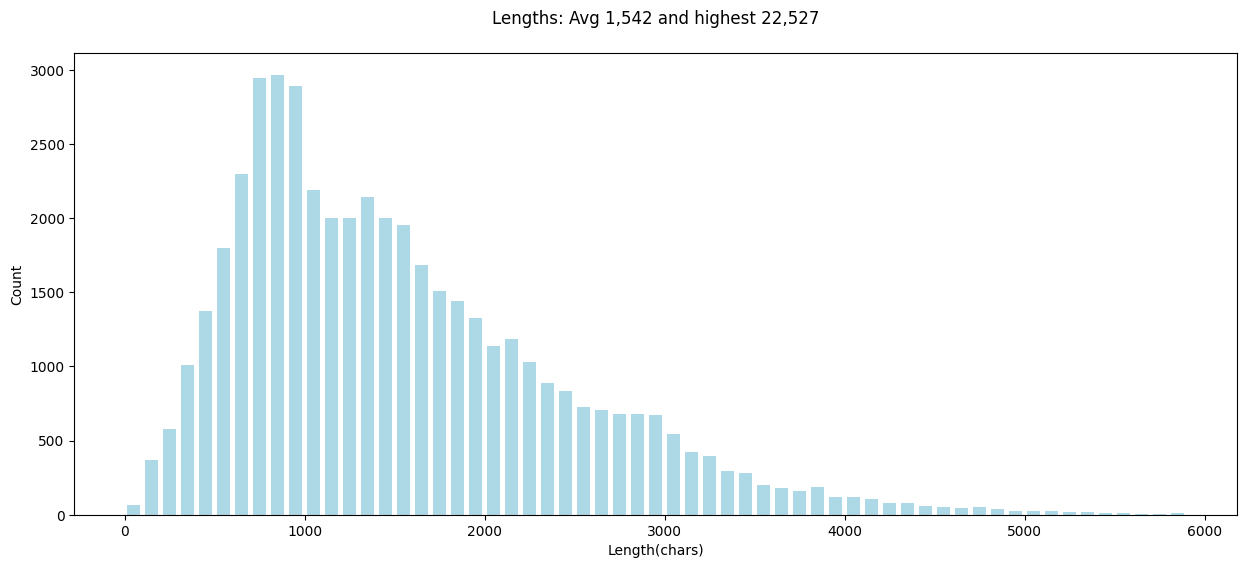

In [18]:
# Plot the distrubution of the lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel("Length(chars)")
plt.ylabel("Count")
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

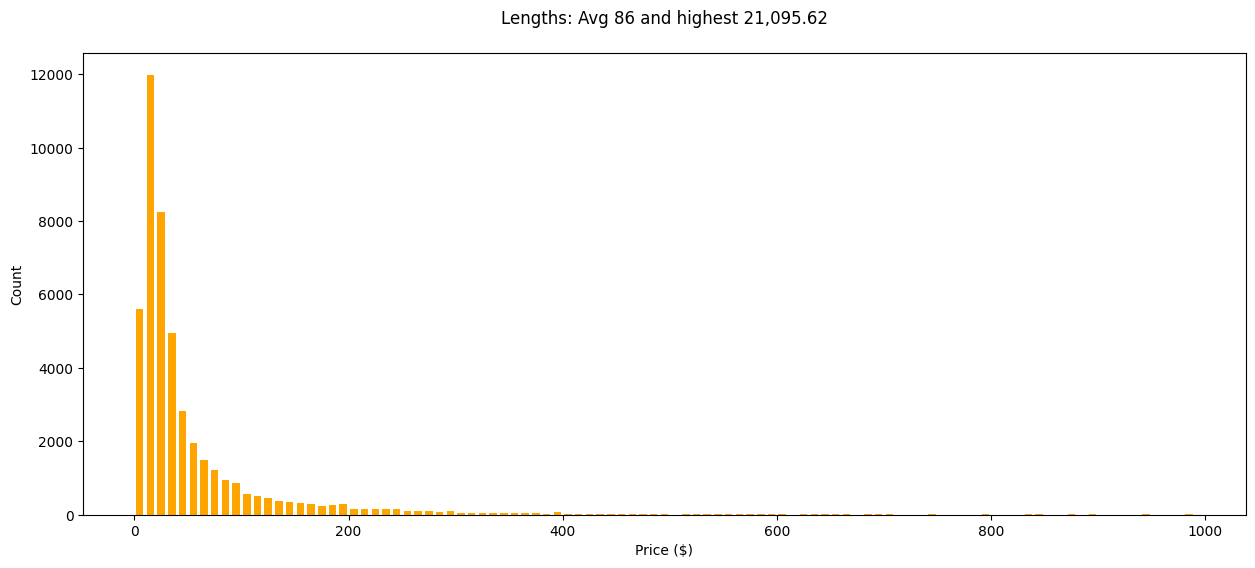

In [19]:
# Plot the distrubution of the prices

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(prices)/len(prices):,.0f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [59]:
# What is this $21,000 item ?

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass    
    

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


### Now its time to curate our Dataset  
We select items that cost between 1 and 999 USD.  
We will create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer.  
And will create prompt to be used during Training.
Items will be rejected if they don't have sufficient characters.

```But why 180 tokens??
why are we truncating to 180 tokens? How did we determine that number?

The answer: this is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. You'll see this in action in Week 7.

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.
```

In [20]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            item = Item(datapoint, price)
            items.append(item) 
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 46,726 items


In [25]:
# Look at the first item

items[12]

<349241T Dryer Drum Roller Kit Whirlpool Kenmore Amana AP3098345 PS347627 Support Part Replacement 110.62832101 110.71402310 WED4815EW0 WED4815EW1 WED49STBW1 WED7000DW0 MEDC465HW0 RED4516FW0 RED4640YQ1 = $7.95>

In [28]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[12].prompt)

How much does this cost to the nearest dollar?

Dryer Drum Roller Kit Whirlpool Kenmore Amana Support Part Replacement
💡 Drum Roller - An equivalent for parts 3436, 8170, 8205, Roller Kit is compatible with Whirlpool, Maytag, KitchenAid, Jenn-Air, Amana, Magic Chef, Admiral, Norge, Roper appliances. The Part is designed to support the drum and help it rotate smoothly during operation. Kit fits hundred of models and can be easily install. 🔧 DIY eTips Included - Not sure how to replace the Dryer Drum Roller Helpful information can be found on the page below. Scroll down to get more repair tips. Acquire valuable skills during the DIY repair project. Whirlpool Drum Roller will help if your appliance does not tumble, is noisy

Price is $8.00


In [ ]:
# Total tokens in the prompt

# NOTE: The items which have the cleaned contents (details + description + features) length < 300 characters, prompts for them is not formed. (see items.py)

print(items[12].token_count)

177


In [29]:
# Investigae the prompt that will be used during testing - the model has to complete this

print(items[12].test_prompt())

How much does this cost to the nearest dollar?

Dryer Drum Roller Kit Whirlpool Kenmore Amana Support Part Replacement
💡 Drum Roller - An equivalent for parts 3436, 8170, 8205, Roller Kit is compatible with Whirlpool, Maytag, KitchenAid, Jenn-Air, Amana, Magic Chef, Admiral, Norge, Roper appliances. The Part is designed to support the drum and help it rotate smoothly during operation. Kit fits hundred of models and can be easily install. 🔧 DIY eTips Included - Not sure how to replace the Dryer Drum Roller Helpful information can be found on the page below. Scroll down to get more repair tips. Acquire valuable skills during the DIY repair project. Whirlpool Drum Roller will help if your appliance does not tumble, is noisy

Price is $


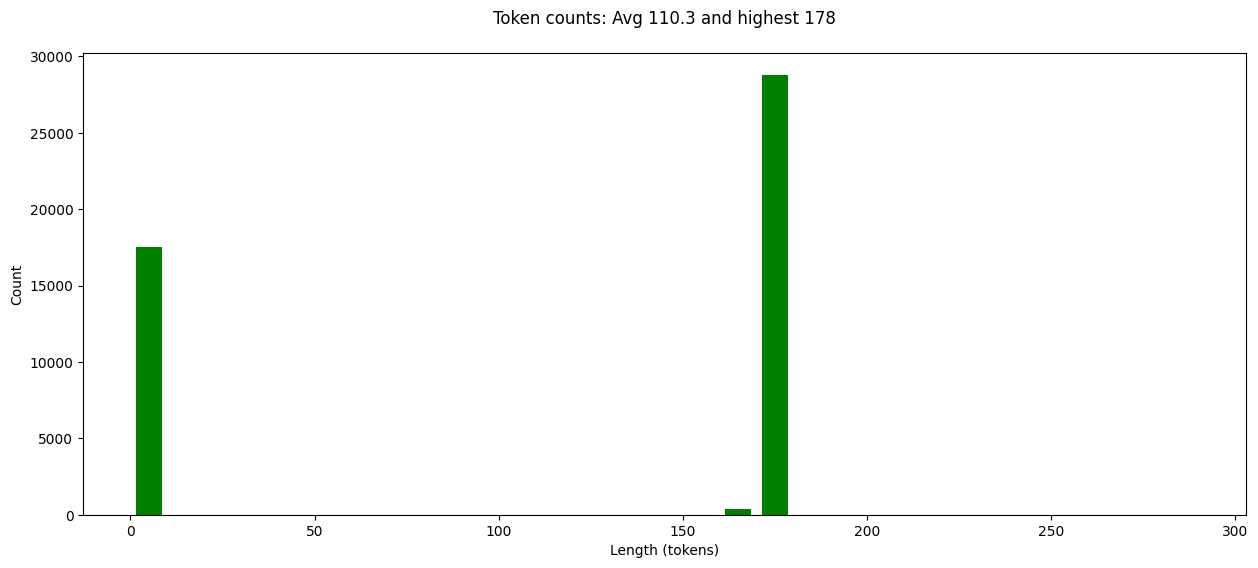

In [31]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

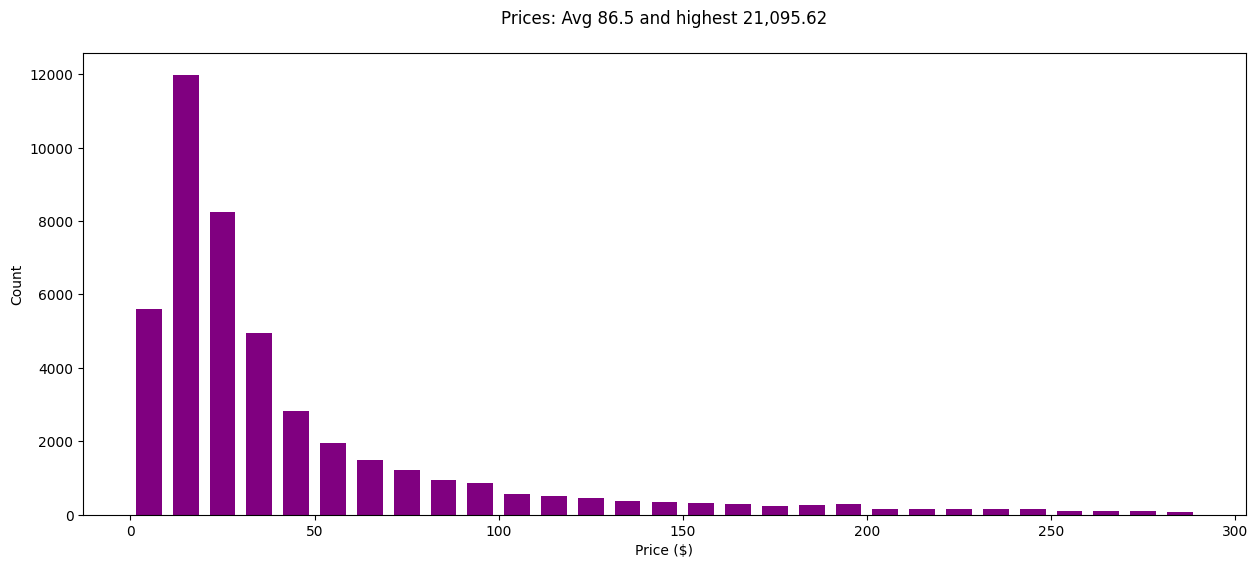

In [32]:

# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()